<h1><center> <b><ins>Unsupervised Learning Trading Algorithm</ins></b> </center></h1>

<h2> <ins>Aims</ins> </h2>
    
In this notebook, we will aim to put together all of the previous projects we have built by creating an unsupervised learning trading algorithm.

My aim is to build a strategy that uses the same stocks as the S&P500 index, but by calculating the features, returns, risks and etc, and then by clustering our stocks (using our K-Means Clustering Algorithm project), we will only take the top stocks based off their sharpe ratios and then create a monthly portfolio out of these at the start of every month. Then we will apply Portfolio Optimisation to find the optimal allocated shares of each stock we should invest in each month by maximising our sharpe ratios. Finally, we will backtest this against a strategy of simply buying and holding the S&P500 index from the start of our investment period to the end.

To best understand how this works, I will firstly give a flowchart showing how our trading algorithm will work.

- Firstly, we will get the historial OHLCV data for all S&P500 stocks from the past 8 years
- Then, we will calculate features for all these stocks, namely:
    -  MACD
    -  RSI
    -  MFI
    -  ATR
    -  Bollinger Bands
    -  Returns with various monthly lookbacks
    -  Fama-French five-factor model
- Now we will use our K-Means Clustering Algorithm to effectively cluster each month's stocks based on all the above features. We will also use the Silhouette Score method to choose the best number of clusters to use for each month
- After clustering, we will choose the best cluster, and all the stocks in said cluster, each month based off the Sharpe ratios to invest in at the start of the subsequent month
- Then for each group of stocks we would like to invest in each month, we will perform Portfolio Optimisation to find the optimal allocated number of integer shares to invest in each stock
- Finally, we will backtest this strategy by calculating the returns, volatility, Sharpe ratio, and other metrics and compare this against a simple benchmark of buying and holding the S&P500 index

In [1]:
# Import fundamental libraries
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.use('ggplot')

# Import our self made Technical Indicators file
from Technical_Indicators import TI

# Import necessary libraries to download Fama French data
import pandas_datareader.data as web
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

# Import K-Means Clustering libraries
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
import sklearn.metrics as metrics

# Import our self made Portfolio Optimisation files
import portfolio_params as params
import portfolio_optimisers as opt
import allocations as alloc
import plotting as plot
import results as results
from Individual_Functions import price_data, returns_data

# Import warnings to supress unecessary warnings
import warnings
import re
# CvxPy gives us a warning when a solution may be inaccurate, we will ignore this message but this block can be deleted if one wants to keep the message
warnings.filterwarnings("ignore",
                        category=UserWarning,
                        message=re.escape("Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information."))

In [2]:
# Read the CSV file with historical S&P500 data
df = pd.read_csv('s&p500.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index(['date', 'ticker'], inplace=True)

# Check dataframe
df

Close        High         Low        Open       Volume
date       ticker                                                             
2017-05-03 A        52.861500   52.955625   52.343804   52.409693    1702600.0
           AAPL     34.113811   34.213561   33.466611   33.772812  182788000.0
           ABBV     47.400528   47.499959   47.024109   47.194562    4993400.0
           ABT      37.930344   37.956370   37.730802   37.834910    4579700.0
           ACGL     30.625275   30.710852   30.450942   30.479468     903300.0
...                       ...         ...         ...         ...          ...
2025-04-30 XYL     120.570000  120.790001  117.040001  118.059998    2701500.0
           YUM     150.440002  151.559998  144.889999  147.490005    3349500.0
           ZBH     103.050003  103.199997  101.250000  102.730003    1399600.0
           ZBRA    250.320007  251.289993  243.529999  246.179993     762600.0
           ZTS     156.399994  157.199997  153.770004  155.720001    2926200.0

[990166 rows x 5 columns]

In [3]:
length_days = 21

"""
Trend Indicators
"""
def macd_calc(df):
    ti = TI(df)
    macd_ = ti.macd()
    return (macd_ - macd_.mean()) / macd_.std()

macd_norm = df.groupby(level=1, group_keys=False).apply(macd_calc).iloc[:,0]
df['macd'] = macd_norm.sort_index()

"""
Momentum Indicators
"""

def rsi_calc(df):
    ti = TI(df)
    rsi_ = ti.rsi(length=length_days)
    return (rsi_ - rsi_.mean()) / rsi_.std()

rsi = df.groupby(level=1, group_keys=False).apply(rsi_calc)
df['rsi'] = rsi.sort_index()

def mfi_calc(df):
    ti = TI(df)
    mfi_ = ti.mfi(length=length_days)
    return (mfi_ - mfi_.mean()) / mfi_.std()

mfi = df.groupby(level=1, group_keys=False).apply(mfi_calc)
df['mfi'] = mfi.sort_index()

"""
Volatility Indicators
"""

def atr_calc(df):
    ti = TI(df)
    atr_ = ti.atr(length=length_days)
    return (atr_ - atr_.mean()) / atr_.std()

atr_norm = df.groupby(level=1, group_keys=False).apply(atr_calc)
df['atr'] = atr_norm.sort_index()


def bbands_calc(df):
    ti = TI(df)
    bbands_ = ti.bbands(length=length_days, data=np.log1p(df['Close']))
    return (bbands_ - bbands_.mean()) / bbands_.std()

bbands = df.groupby(level=1, group_keys=False).apply(bbands_calc).iloc[:,:3]
df[['bbands_low', 'bbands_mid', 'bbands_high']] = bbands.sort_index()

df

Close        High         Low        Open  \
date       ticker                                                   
2017-05-03 A        52.861500   52.955625   52.343804   52.409693   
           AAPL     34.113811   34.213561   33.466611   33.772812   
           ABBV     47.400528   47.499959   47.024109   47.194562   
           ABT      37.930344   37.956370   37.730802   37.834910   
           ACGL     30.625275   30.710852   30.450942   30.479468   
...                       ...         ...         ...         ...   
2025-04-30 XYL     120.570000  120.790001  117.040001  118.059998   
           YUM     150.440002  151.559998  144.889999  147.490005   
           ZBH     103.050003  103.199997  101.250000  102.730003   
           ZBRA    250.320007  251.289993  243.529999  246.179993   
           ZTS     156.399994  157.199997  153.770004  155.720001   

                        Volume      macd       rsi       mfi       atr  \
date       ticker                                                        
2017-05-03 A         1702600.0       NaN       NaN       NaN       NaN   
           AAPL    182788000.0       NaN       NaN       NaN       NaN   
           ABBV      4993400.0       NaN       NaN       NaN       NaN   
           ABT       4579700.0       NaN       NaN       NaN       NaN   
           ACGL       903300.0       NaN       NaN       NaN       NaN   
...                        ...       ...       ...       ...       ...   
2025-04-30 XYL       2701500.0 -0.253761  0.193850  0.540009  2.182497   
           YUM       3349500.0 -0.932797 -0.089122 -0.220920  2.777972   
           ZBH       1399600.0 -0.691311 -0.290934 -0.881744  0.165825   
           ZBRA       762600.0 -1.020390 -0.703093 -0.530278  1.253364   
           ZTS       2926200.0 -0.732073 -0.371818 -0.424753  1.173958   

                   bbands_low  bbands_mid  bbands_high  
date       ticker                                       
2017-05-03 A              NaN         NaN          NaN  
           AAPL           NaN         NaN          NaN  
           ABBV           NaN         NaN          NaN  
           ABT            NaN         NaN          NaN  
           ACGL           NaN         NaN          NaN  
...                       ...         ...          ...  
2025-04-30 XYL       0.768872    0.911080     1.042743  
           YUM       1.436374    1.595082     1.724988  
           ZBH      -1.367103   -1.209268    -0.906113  
           ZBRA     -0.324990   -0.170529    -0.014882  
           ZTS       0.355248    0.386698     0.414940  

[990166 rows x 12 columns]

In [4]:
# Calculate dollar volumes of each stock for each day
df['dollar_volume'] = (df['Close']*df['Volume'])/1e6

# Depending on the feature, when aggregating to a monthly level, we will either take a mean of the month or the last value of the month
mean_cols = ['dollar_volume', 'atr', 'bbands_low', 'bbands_mid', 'bbands_high']

last_cols = [c for c in df.columns.unique(0) if c not in (['Volume', 'Open', 'High', 'Low'] + mean_cols)]

df_monthly = (pd.concat([df.unstack('ticker')[mean_cols].resample('ME').mean().stack('ticker',future_stack=True),
                   df.unstack()[last_cols].resample('ME').last().stack('ticker',future_stack=True)],
                  axis=1)).dropna()

cols_remove = ['Volume', 'Open', 'High', 'Low', 'dollar_volume']
cols_order = ['dollar_volume']+[col for col in df.columns.unique().to_list() if col not in cols_remove]

df_monthly = df_monthly[cols_order]
df_monthly

dollar_volume       Close      macd       rsi       mfi  \
date       ticker                                                            
2017-06-30 A          109.548805   55.950836  0.082164  0.123639 -0.474822   
           AAPL      4268.541202   33.546528 -0.415543 -1.230755 -0.771653   
           ABBV       298.847303   51.498543  0.286278  1.556613  1.989490   
           ABT        302.877900   42.172787  0.444269  1.660504  1.665396   
           ACGL        69.558512   29.569775 -0.406436 -1.191900 -1.238650   
...                          ...         ...       ...       ...       ...   
2025-04-30 XYL        261.993113  120.570000 -0.253761  0.193850  0.540009   
           YUM        407.054752  150.440002 -0.932797 -0.089122 -0.220920   
           ZBH        234.939201  103.050003 -0.691311 -0.290934 -0.881744   
           ZBRA       200.772721  250.320007 -1.020390 -0.703093 -0.530278   
           ZTS        457.404349  156.399994 -0.732073 -0.371818 -0.424753   

                        atr  bbands_low  bbands_mid  bbands_high  
date       ticker                                                 
2017-06-30 A      -1.545930   -1.708896   -1.735707    -1.751506  
           AAPL   -1.343627   -1.603753   -1.633819    -1.660475  
           ABBV   -1.727287   -1.701248   -1.746411    -1.780162  
           ABT    -1.790510   -2.551207   -2.506030    -2.446741  
           ACGL   -1.215898   -0.781653   -0.838614    -0.888963  
...                     ...         ...         ...          ...  
2025-04-30 XYL     2.070742    0.861459    1.043877     1.214531  
           YUM     2.669547    1.585143    1.736957     1.856760  
           ZBH     0.242974   -0.958254   -0.836596    -0.613009  
           ZBRA    1.181889   -0.197691    0.027762     0.252648  
           ZTS     1.307603    0.430648    0.485957     0.536839  

[46795 rows x 9 columns]

In [5]:
# Now we will take the top 150 liquid stocks by the dollar volume
df_monthly['dollar_volume'] = (df_monthly.loc[:,'dollar_volume'].unstack('ticker').rolling(60, min_periods=12).mean().stack())

df_monthly['dollar_vol_rank'] = (df_monthly.groupby('date')['dollar_volume'].rank(ascending=False))

df_monthly = df_monthly[df_monthly['dollar_vol_rank']<=150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

df_monthly

Close      macd       rsi       mfi       atr  \
date       ticker                                                       
2018-05-31 AAPL     44.204174  0.084903  0.491721  0.623771 -1.160625   
           ABBV     72.653084  0.017720 -0.675556 -0.758225 -0.114013   
           ABT      54.458668  0.209988  0.053248  0.274661 -1.034238   
           ACN     140.315765 -0.004947 -0.141257  0.075715 -1.029112   
           ADBE    249.279999  0.459558  1.283799  1.976624 -1.072728   
...                       ...       ...       ...       ...       ...   
2025-04-30 VZ       44.060001 -0.092963  0.416128 -0.037989  2.414240   
           WDAY    245.000000 -0.161235  0.183445 -0.263446  1.486011   
           WFC      70.622551 -0.071040  0.173391  0.807908  4.524662   
           WMT      97.015434  2.295371  0.407056  0.695548  5.098351   
           XOM     104.666008 -0.822138 -0.618386 -0.773378  2.223115   

                   bbands_low  bbands_mid  bbands_high  
date       ticker                                       
2018-05-31 AAPL     -1.417890   -1.373385    -1.326131  
           ABBV     -0.787494   -0.747915    -0.702485  
           ABT      -1.568696   -1.599519    -1.620640  
           ACN      -1.295252   -1.349667    -1.394651  
           ADBE     -1.145415   -1.166327    -1.177195  
...                       ...         ...          ...  
2025-04-30 VZ        0.875012    0.954450     1.019295  
           WDAY      0.715467    0.780298     0.832331  
           WFC       1.602961    1.867229     2.103916  
           WMT       2.094320    2.170177     2.233036  
           XOM       1.174779    1.339570     1.500558  

[12600 rows x 8 columns]

In [6]:
# Calculate average monthly returns over different lookback periods, with outliers clipped to reduce noise.
def calculate_returns(df):

    # Outlier clipping threshold
    outlier_cutoff = 0.005

    # Lookback periods (in months)
    lookbacks = [1, 3, 6, 9, 12]

    # Loop over each lookback to compute returns
    for lookback in lookbacks:
        raw_return = df['Close'].pct_change(lookback)

        lower_bound = raw_return.quantile(outlier_cutoff)
        upper_bound = raw_return.quantile(1 - outlier_cutoff)
        clipped_return = raw_return.clip(lower=lower_bound, upper=upper_bound)

        df[f'return_{lookback}m'] = ((clipped_return + 1).pow(1 / lookback).sub(1))

    return df

# Apply the function
df_monthly = (df_monthly.groupby(level=1, group_keys=False).apply(calculate_returns).dropna())

df_monthly

Close      macd       rsi       mfi       atr  \
date       ticker                                                       
2019-05-31 AAPL     42.043270 -0.785566 -1.868596 -2.016343 -1.027299   
           ABBV     58.990604 -0.346709 -1.157025 -0.538943 -1.043535   
           ABT      68.556488 -0.474654 -0.613367 -1.589765 -0.722268   
           ACN     163.241531  0.001265  0.067511 -1.179242 -1.104639   
           ADBE    270.899994 -0.104351 -0.509922 -0.800541 -1.024368   
...                       ...       ...       ...       ...       ...   
2025-04-30 VZ       44.060001 -0.092963  0.416128 -0.037989  2.414240   
           WDAY    245.000000 -0.161235  0.183445 -0.263446  1.486011   
           WFC      70.622551 -0.071040  0.173391  0.807908  4.524662   
           WMT      97.015434  2.295371  0.407056  0.695548  5.098351   
           XOM     104.666008 -0.822138 -0.618386 -0.773378  2.223115   

                   bbands_low  bbands_mid  bbands_high  return_1m  return_3m  \
date       ticker                                                              
2019-05-31 AAPL     -1.172081   -1.158116    -1.141794  -0.124213   0.004969   
           ABBV     -1.094091   -1.170764    -1.240546  -0.033757  -0.006405   
           ABT      -0.682039   -0.699731    -0.713129  -0.043112  -0.005087   
           ACN      -0.831662   -0.879951    -0.921664  -0.025182   0.036194   
           ADBE     -0.615636   -0.683777    -0.744320  -0.063440   0.010555   
...                       ...         ...          ...        ...        ...   
2025-04-30 VZ        0.875012    0.954450     1.019295  -0.013058   0.043581   
           WDAY      0.715467    0.780298     0.832331   0.049116  -0.022189   
           WFC       1.602961    1.867229     2.103916  -0.010865  -0.032515   
           WMT       2.094320    2.170177     2.233036   0.107757  -0.002188   
           XOM       1.174779    1.339570     1.500558  -0.111830  -0.000797   

                   return_6m  return_9m  return_12m  
date       ticker                                    
2019-05-31 AAPL    -0.001953  -0.027496   -0.004168  
           ABBV    -0.029679  -0.020684   -0.017210  
           ABT      0.006087   0.016011    0.019370  
           ACN      0.014672   0.007720    0.012691  
           ADBE     0.012871   0.003078    0.006955  
...                      ...        ...         ...  
2025-04-30 VZ       0.013134   0.014859    0.014667  
           WDAY     0.007793   0.008456    0.000092  
           WFC      0.016863   0.022223    0.017136  
           WMT      0.029790   0.040373    0.042989  
           XOM     -0.013781  -0.010019   -0.006631  

[10405 rows x 13 columns]

In [7]:
# Load Fama-French 5-Factor Data
factors = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0]
factors = factors.drop('RF', axis=1)
factors.index = factors.index.to_timestamp()
factors = factors.resample('ME').last().div(100)
factors.index.name = 'date'

# Join with stock returns data
factors = factors.join(df_monthly['return_1m']).sort_index()
factors

/var/folders/m_/x9d7qhbs7vj7q3w25975531m0000gn/T/ipykernel_10683/1904019048.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0]
/var/folders/m_/x9d7qhbs7vj7q3w25975531m0000gn/T/ipykernel_10683/1904019048.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0]


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-05-31 AAPL   -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.124213
           ABBV   -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.033757
           ABT    -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.043112
           ACN    -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.025182
           ADBE   -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.063440
...                   ...     ...     ...     ...     ...        ...
2025-04-30 VZ     -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.013058
           WDAY   -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.049116
           WFC    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.010865
           WMT    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.107757
           XOM    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.111830

[10405 rows x 6 columns]

In [8]:
# Ensure we have at least 10 months of data for each stock
n = factors.groupby(level='ticker').size()
valid_stocks = n[n >= 10].index
factors = factors[factors.index.get_level_values('ticker').isin(valid_stocks)]
factors

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-05-31 AAPL   -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.124213
           ABBV   -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.033757
           ABT    -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.043112
           ACN    -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.025182
           ADBE   -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.063440
...                   ...     ...     ...     ...     ...        ...
2025-04-30 VZ     -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.013058
           WDAY   -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.049116
           WFC    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.010865
           WMT    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.107757
           XOM    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.111830

[10346 rows x 6 columns]

In [9]:
# Calculate rolling factor betas
def compute_rolling_betas(df):
    y = df['return_1m']
    X = sm.add_constant(df.drop(columns='return_1m'))
    
    window = min(24, len(df))
    min_obs = len(X.columns)
    
    model = RollingOLS(endog=y, exog=X, window=window, min_nobs=min_obs)
    results = model.fit(params_only=True)
    
    return results.params.drop('const', axis=1)

betas = factors.groupby(level='ticker', group_keys=False).apply(compute_rolling_betas)
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-05-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-04-30 VZ      0.904802 -1.064600  0.905389  0.657992 -0.070619
           WDAY    1.108715 -0.937077  0.037348 -1.896113 -0.421493
           WFC     0.877758 -0.095224  0.559151 -1.655163 -0.085205
           WMT     0.787344  0.091226 -0.722477  0.394636  0.633477
           XOM     0.476823 -0.287361  1.039672  1.215638  0.114549

[10346 rows x 5 columns]

In [10]:
# Fill missing factor exposures with ticker-specific historical betas
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Shift betas for next month’s prediction (no lookahead)
shifted_betas = betas.groupby('ticker').shift()

# Join shifted betas to monthly data
df_full = df_monthly.join(shifted_betas)

# Fill missing factor exposures:
df_full.loc[:, factors] = (df_full.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.ffill().fillna(x.mean())))

# Drop unnecessary columns and any remaining NaNs
df_full = df_full.drop(columns='Close')
df_full = df_full.dropna()

# Final dataset
df_full

macd       rsi       mfi       atr  bbands_low  \
date       ticker                                                       
2019-05-31 AAPL   -0.785566 -1.868596 -2.016343 -1.027299   -1.172081   
           ABBV   -0.346709 -1.157025 -0.538943 -1.043535   -1.094091   
           ABT    -0.474654 -0.613367 -1.589765 -0.722268   -0.682039   
           ACN     0.001265  0.067511 -1.179242 -1.104639   -0.831662   
           ADBE   -0.104351 -0.509922 -0.800541 -1.024368   -0.615636   
...                     ...       ...       ...       ...         ...   
2025-04-30 VZ     -0.092963  0.416128 -0.037989  2.414240    0.875012   
           WDAY   -0.161235  0.183445 -0.263446  1.486011    0.715467   
           WFC    -0.071040  0.173391  0.807908  4.524662    1.602961   
           WMT     2.295371  0.407056  0.695548  5.098351    2.094320   
           XOM    -0.822138 -0.618386 -0.773378  2.223115    1.174779   

                   bbands_mid  bbands_high  return_1m  return_3m  return_6m  \
date       ticker                                                             
2019-05-31 AAPL     -1.158116    -1.141794  -0.124213   0.004969  -0.001953   
           ABBV     -1.170764    -1.240546  -0.033757  -0.006405  -0.029679   
           ABT      -0.699731    -0.713129  -0.043112  -0.005087   0.006087   
           ACN      -0.879951    -0.921664  -0.025182   0.036194   0.014672   
           ADBE     -0.683777    -0.744320  -0.063440   0.010555   0.012871   
...                       ...          ...        ...        ...        ...   
2025-04-30 VZ        0.954450     1.019295  -0.013058   0.043581   0.013134   
           WDAY      0.780298     0.832331   0.049116  -0.022189   0.007793   
           WFC       1.867229     2.103916  -0.010865  -0.032515   0.016863   
           WMT       2.170177     2.233036   0.107757  -0.002188   0.029790   
           XOM       1.339570     1.500558  -0.111830  -0.000797  -0.013781   

                   return_9m  return_12m    Mkt-RF       SMB       HML  \
date       ticker                                                        
2019-05-31 AAPL    -0.027496   -0.004168  1.238619 -0.088875 -0.690893   
           ABBV    -0.020684   -0.017210  0.542049  0.139724 -0.054982   
           ABT      0.016011    0.019370  0.788777 -0.067623 -0.351328   
           ACN      0.007720    0.012691  1.151801 -0.182066 -0.239062   
           ADBE     0.003078    0.006955  1.381149 -0.633805 -0.222655   
...                      ...         ...       ...       ...       ...   
2025-04-30 VZ       0.014859    0.014667  0.959162 -1.093275  1.057762   
           WDAY     0.008456    0.000092  1.030206 -1.009928  0.260714   
           WFC      0.022223    0.017136  0.790556 -0.006035  0.147107   
           WMT      0.040373    0.042989  0.969314  0.042702 -0.396603   
           XOM     -0.010019   -0.006631  0.432075 -0.233825  0.798082   

                        RMW       CMA  
date       ticker                      
2019-05-31 AAPL    0.377268  0.417995  
           ABBV    0.270812  0.577818  
           ABT     0.057437  1.010629  
           ACN     0.204164 -0.043254  
           ADBE    0.275130 -0.444024  
...                     ...       ...  
2025-04-30 VZ      0.790968 -0.260801  
           WDAY   -2.140773 -0.909356  
           WFC    -1.848593  0.508107  
           WMT     0.861629  0.313590  
           XOM     1.119958  0.470854  

[10187 rows x 17 columns]

In [11]:
# Calculate the optimal number of clusters for each month
cluster_num = []

dates = df_full.index.get_level_values(0).unique()
for date in dates:
    df_test = df_full.loc[date]
    
    # Calculating Silhouette Scores
    SK = [4,5,6]
    sil_score = []
    
    for i in SK:
        labels = cluster.KMeans(n_clusters=i,
                                init="k-means++",
                                random_state=0).fit(df_test).labels_
        score = metrics.silhouette_score(df_test,labels,
                                         metric="euclidean",
                                         sample_size=100_000,random_state=0)
        sil_score.append(score)

    max_index = np.argmax(sil_score)
    cluster_num.append(SK[max_index])

clusters = pd.Series(cluster_num, index=df_full.index.get_level_values(0).unique())
clusters

date
2019-05-31    4
2019-06-30    4
2019-07-31    4
2019-08-31    4
2019-09-30    4
             ..
2024-12-31    6
2025-01-31    4
2025-02-28    4
2025-03-31    4
2025-04-30    4
Length: 72, dtype: int64

In [12]:
# Cluster our data with K-Means
def get_clusters(df,n):
    df['cluster'] = KMeans(n_clusters=n,
                           random_state=0,
                           init='k-means++').fit(df).labels_
    return df

df_clustered = df_full.groupby('date', group_keys=False).apply(lambda df: get_clusters(df, clusters.loc[df.name]))
df_clustered

macd       rsi       mfi       atr  bbands_low  \
date       ticker                                                       
2019-05-31 AAPL   -0.785566 -1.868596 -2.016343 -1.027299   -1.172081   
           ABBV   -0.346709 -1.157025 -0.538943 -1.043535   -1.094091   
           ABT    -0.474654 -0.613367 -1.589765 -0.722268   -0.682039   
           ACN     0.001265  0.067511 -1.179242 -1.104639   -0.831662   
           ADBE   -0.104351 -0.509922 -0.800541 -1.024368   -0.615636   
...                     ...       ...       ...       ...         ...   
2025-04-30 VZ     -0.092963  0.416128 -0.037989  2.414240    0.875012   
           WDAY   -0.161235  0.183445 -0.263446  1.486011    0.715467   
           WFC    -0.071040  0.173391  0.807908  4.524662    1.602961   
           WMT     2.295371  0.407056  0.695548  5.098351    2.094320   
           XOM    -0.822138 -0.618386 -0.773378  2.223115    1.174779   

                   bbands_mid  bbands_high  return_1m  return_3m  return_6m  \
date       ticker                                                             
2019-05-31 AAPL     -1.158116    -1.141794  -0.124213   0.004969  -0.001953   
           ABBV     -1.170764    -1.240546  -0.033757  -0.006405  -0.029679   
           ABT      -0.699731    -0.713129  -0.043112  -0.005087   0.006087   
           ACN      -0.879951    -0.921664  -0.025182   0.036194   0.014672   
           ADBE     -0.683777    -0.744320  -0.063440   0.010555   0.012871   
...                       ...          ...        ...        ...        ...   
2025-04-30 VZ        0.954450     1.019295  -0.013058   0.043581   0.013134   
           WDAY      0.780298     0.832331   0.049116  -0.022189   0.007793   
           WFC       1.867229     2.103916  -0.010865  -0.032515   0.016863   
           WMT       2.170177     2.233036   0.107757  -0.002188   0.029790   
           XOM       1.339570     1.500558  -0.111830  -0.000797  -0.013781   

                   return_9m  return_12m    Mkt-RF       SMB       HML  \
date       ticker                                                        
2019-05-31 AAPL    -0.027496   -0.004168  1.238619 -0.088875 -0.690893   
           ABBV    -0.020684   -0.017210  0.542049  0.139724 -0.054982   
           ABT      0.016011    0.019370  0.788777 -0.067623 -0.351328   
           ACN      0.007720    0.012691  1.151801 -0.182066 -0.239062   
           ADBE     0.003078    0.006955  1.381149 -0.633805 -0.222655   
...                      ...         ...       ...       ...       ...   
2025-04-30 VZ       0.014859    0.014667  0.959162 -1.093275  1.057762   
           WDAY     0.008456    0.000092  1.030206 -1.009928  0.260714   
           WFC      0.022223    0.017136  0.790556 -0.006035  0.147107   
           WMT      0.040373    0.042989  0.969314  0.042702 -0.396603   
           XOM     -0.010019   -0.006631  0.432075 -0.233825  0.798082   

                        RMW       CMA  cluster  
date       ticker                               
2019-05-31 AAPL    0.377268  0.417995        1  
           ABBV    0.270812  0.577818        3  
           ABT     0.057437  1.010629        3  
           ACN     0.204164 -0.043254        3  
           ADBE    0.275130 -0.444024        3  
...                     ...       ...      ...  
2025-04-30 VZ      0.790968 -0.260801        3  
           WDAY   -2.140773 -0.909356        3  
           WFC    -1.848593  0.508107        1  
           WMT     0.861629  0.313590        1  
           XOM     1.119958  0.470854        3  

[10187 rows x 18 columns]

In [13]:
# Calculate mean and std dev of returns for each date & cluster
cluster_stats = (df_clustered.groupby(['date', 'cluster'])['return_3m']
                 .agg(['mean', 'std'])
                 .reset_index())

# Compute the Sharpe ratio
cluster_stats['sharpe'] = cluster_stats['mean'] / cluster_stats['std']

# Find the cluster with the highest Sharpe ratio for each date
best_clusters = (cluster_stats.loc[cluster_stats.groupby('date')['sharpe'].idxmax()])

# Merge to get stocks in the best cluster
best_clusters_df = (df_clustered.reset_index()
                    .merge(best_clusters[['date', 'cluster']],
                           on=['date', 'cluster'],
                           how='inner'))

# Add a day to each end of the month date, since we will be investing at the start of the subsequent month
best_clusters_df['date'] = best_clusters_df['date'] + pd.DateOffset(1)

# Cap top 30 stocks by return
def get_capped_stocks(group, cap=30):
    group = group.sort_values('return_3m', ascending=False)
    top_stocks = group['ticker'].head(cap).tolist()
    return sorted(top_stocks)

# Create a dictionary with a set of stocks we will invest in at the start of each month
best_stocks_by_date = (best_clusters_df.groupby('date')
                       .apply(lambda group: get_capped_stocks(group, cap=30), include_groups=False)
                       .to_dict())

# Print to confirm
# for date, tickers in best_stocks_by_date.items():
#     print(f"{date}: {tickers}")

In [14]:
# Get an alphabetically sorted list of stocks we have invested in across our entire investment period
stocks = sorted(list(set(ticker for sublist in best_stocks_by_date.values() for ticker in sublist)))

# Download fresh closing price data for these stocks so we can use it for both portfolio optimisation and backtesting our strategy
new_df = yf.download(tickers=stocks,
                     start=df_clustered.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=(pd.to_datetime(list(best_stocks_by_date.keys())[-1])+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d'),
                     auto_adjust=True)['Close']

new_df

[*********************100%***********************]  154 of 154 completed


Ticker,AAPL,ABBV,ABNB,ABT,ACN,ADBE,ADI,ADP,ADSK,ALGN,...,VLO,VRTX,VZ,WBA,WDAY,WDC,WFC,WMT,WYNN,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2018-05-31,44.204170,72.653076,NaN,54.458668,140.315765,249.279999,84.862671,112.242455,129.100006,331.950012,...,90.789597,154.000000,32.818264,45.450096,130.960007,60.254063,44.283939,24.612322,181.473160,58.538063
2018-06-01,45.001354,71.999535,NaN,55.237526,143.153809,251.309998,85.928040,114.581932,133.520004,333.089996,...,92.722221,152.050003,32.914650,45.792488,126.290001,61.956856,44.858105,24.746506,178.223465,58.963181
2018-06-04,45.377464,72.770576,NaN,55.777435,143.640274,253.339996,87.307762,115.894112,135.570007,343.200012,...,93.216629,149.649994,32.921528,46.113022,128.149994,61.220901,44.972935,25.471100,169.270660,58.343517
2018-06-05,45.727562,72.873383,NaN,55.786285,144.081741,252.699997,87.884109,115.738716,136.800003,346.079987,...,92.385139,145.720001,33.024788,45.814339,128.710007,61.978493,44.702255,25.232552,163.761948,58.134556
2018-06-06,45.886059,73.416779,NaN,56.237663,146.595428,253.949997,89.159042,117.491158,137.929993,346.369995,...,90.789597,145.970001,33.327709,46.003746,128.309998,61.127098,45.588100,25.214657,166.196869,59.128902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,195.270004,183.259995,126.720001,131.300003,309.579987,407.690002,209.516083,321.089996,295.350006,170.800003,...,128.550003,436.000000,43.320000,11.170000,238.009995,50.086678,72.830002,96.339996,90.470001,103.029999
2025-05-27,200.210007,185.720001,129.399994,132.940002,315.429993,413.100006,215.906982,325.709991,300.359985,178.550003,...,130.710007,446.000000,43.500000,11.210000,239.300003,51.723625,73.989998,97.580002,92.540001,103.519997
2025-05-28,200.419998,183.089996,128.669998,132.020004,315.989990,412.230011,214.642731,324.140015,299.230011,180.110001,...,126.930000,445.100006,43.130001,11.190000,239.899994,52.252640,73.730003,97.239998,90.940002,102.110001


In [15]:
# Calculate daily returns from our fresh closing price dataset
ret_df = new_df.pct_change().dropna(axis=0, how='all')
ret_df

Ticker,AAPL,ABBV,ABNB,ABT,ACN,ADBE,ADI,ADP,ADSK,ALGN,...,VLO,VRTX,VZ,WBA,WDAY,WDC,WFC,WMT,WYNN,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-01,0.018034,-0.008995,NaN,0.014302,0.020226,0.008143,0.012554,0.020843,0.034237,0.003434,...,0.021287,-0.012662,0.002937,0.007533,-0.035660,0.028260,0.012966,0.005452,-0.017907,0.007262
2018-06-04,0.008358,0.010709,NaN,0.009774,0.003398,0.008078,0.016057,0.011452,0.015354,0.030352,...,0.005332,-0.015784,0.000209,0.007000,0.014728,-0.011878,0.002560,0.029281,-0.050234,-0.010509
2018-06-05,0.007715,0.001413,NaN,0.000159,0.003073,-0.002526,0.006601,-0.001341,0.009073,0.008392,...,-0.008920,-0.026261,0.003137,-0.006477,0.004370,0.012375,-0.006019,-0.009365,-0.032544,-0.003582
2018-06-06,0.003466,0.007457,NaN,0.008091,0.017446,0.004947,0.014507,0.015141,0.008260,0.000838,...,-0.017271,0.001716,0.009173,0.004134,-0.003108,-0.013737,0.019817,-0.000709,0.014869,0.017104
2018-06-07,-0.002681,-0.006601,NaN,-0.005666,-0.012906,-0.025359,0.003346,-0.006130,-0.027478,-0.020354,...,0.002393,-0.001507,0.012394,0.007126,-0.038500,-0.025023,0.000899,0.004612,-0.018161,0.009993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,-0.030244,0.003944,-0.007286,-0.001521,-0.021710,-0.016026,-0.006889,-0.001741,0.001186,-0.010486,...,-0.001321,0.004539,0.004405,-0.006228,-0.125188,0.006822,-0.007630,0.004274,-0.004840,0.000583
2025-05-27,0.025298,0.013424,0.021149,0.012490,0.018897,0.013270,0.030503,0.014388,0.016963,0.045375,...,0.016803,0.022936,0.004155,0.003581,0.005420,0.032682,0.015927,0.012871,0.022881,0.004756
2025-05-28,0.001049,-0.014161,-0.005641,-0.006920,0.001775,-0.002106,-0.005856,-0.004820,-0.003762,0.008737,...,-0.028919,-0.002018,-0.008506,-0.001784,0.002507,0.010228,-0.003514,-0.003484,-0.017290,-0.013621


In [16]:
# Define a function to find the optimal allocation of shares for the selected investment stocks each month
def optimise_alloc(prices_df, risk_free_rate, start_date, total_investment):

    ret_df = prices_df.pct_change().dropna(axis=0, how='all')
    #ret_df = ret_df.mask(ret_df.ffill().isnull(), 0)
    
    parameters = params.parameters(ret_df, frequency=252, risk_free_rate=risk_free_rate)
    mu = parameters.expected_returns_capm()
    cov,cov_df = parameters.covariance_matrix_ledoit_wolf()
    
    opts = opt.optimisers(mu, cov, weight_bounds=[-1,1])

    success = False
    try:
        ret_maxsr, risk_maxsr, weights_maxsr = opts.maximise_sharpe_ratio(risk_free_rate=risk_free_rate)
        success = True

    except:
        print(f"Max Sharpe Optimization failed for {start_date.strftime('%Y-%m-%d')}, continuing with Equal-Weights")

    if success == False:
        weights_maxsr = pd.Series([1/len(optimisation_df.columns) for i in range(len(optimisation_df.columns))],
                                     index=optimisation_df.columns.to_list())

    success = False
    try:
        allocations, leftovers = alloc.allocation(prices_df.iloc[-1], weights_maxsr, total_investment=total_investment, short_ratio=0.3, reinvest=True, remove_zero_investments=False)
        success = True

    except:
        print(f"Allocation Optimization failed for {start_date.strftime('%Y-%m-%d')}, continuing with Minimal-Allocation")

    if success == False:        
        dollar_allocation = weights_maxsr * total_investment
        allocations = np.floor(dollar_allocation / prices_df.iloc[-1]).astype(int)
        leftovers = total_investment - (allocations * prices_df.iloc[-1]).sum()
    
    return allocations, leftovers

In [17]:
# Initialise empty dataframe to store our strategy's daily portfolio returns
portfolio_returns = pd.DataFrame()
# This is our starting initial investment amount
total_investment = 10_000

# We will go through each month and find the optimal allocation of shares and the daily portfolio returns 
for start_date in best_stocks_by_date.keys():
    # Our end dates will be the end of each month
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    
    # Get the list of stocks we want to invest in this month
    cols = best_stocks_by_date[start_date]
    
    # Calculate date ranges for optimising our monthly portfolio
    optimisation_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    optimisation_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    
    # Slice our optimisation closing price dataframe that only contains our optimisation range and the stocks we want to ivnest in
    optimisation_df = new_df[optimisation_start_date:optimisation_end_date][cols]
    
    # Use our previously defined function to find the optimal allocation of shares and the leftover cash we have
    allocation, leftover = optimise_alloc(optimisation_df, risk_free_rate=0.041, start_date=start_date, total_investment=total_investment)

    # Slice to get daily prices for the month we are investing in
    daily_prices = new_df.loc[start_date:end_date, cols]
    
    # Calculate daily portfolio value for each stock by multiplying prices by allocated number of shares
    daily_value = daily_prices * allocation
    
    # Sum to get total daily portfolio value and add on the leftover cash we did not use for investing
    daily_portfolio_value = daily_value.sum(axis=1) + leftover
    
    # Calculate daily returns as percentage change
    daily_portfolio_return = daily_portfolio_value.pct_change().fillna(0)

    # Check and handle empty portfolio_returns, but add on the daily portfolio returns across a month to the dataframe
    if portfolio_returns.empty:
        portfolio_returns = daily_portfolio_return
    else:
        portfolio_returns = pd.concat([portfolio_returns, daily_portfolio_return])

    # Update the amount we would like to invest for each month, we will invest all our profits back into the strategy
    total_investment = daily_portfolio_value.iloc[-1]

# Drop any duplicates and ensure it is a nice dataframe
portfolio_returns = portfolio_returns.to_frame(name='Strategy Return')
#portfolio_returns = portfolio_returns.drop_duplicates()
portfolio_returns

Max Sharpe Optimization failed for 2020-12-01, continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-01-01, continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-05-01, continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-08-01, continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-03-01, continuing with Equal-Weights


,Strategy Return
Date,
2019-06-03,0.000000
2019-06-04,0.019122
2019-06-05,0.012266
2019-06-06,0.009550
2019-06-07,0.013847
...,...
2025-05-23,-0.003173
2025-05-27,0.016631
2025-05-28,-0.003726


In [18]:
# Download the S&P500 price history
spyticker = yf.Ticker("SPY")
df_ticker = spyticker.history(interval="1d", start="2019-06-01", end='2025-06-01', auto_adjust=True)

# Calculate the daily returns of S&P500 index
spy_ret = df_ticker[['Close']].pct_change().dropna()
spy_ret.columns = ['SPY Buy&Hold']
spy_ret.index = spy_ret.index.tz_localize(None)

first_row = pd.DataFrame([[0]], columns=spy_ret.columns, index=[portfolio_returns.index[0]])
spy_ret = pd.concat([first_row, spy_ret])

spy_ret

,SPY Buy&Hold
2019-06-03,0.000000
2019-06-04,0.021707
2019-06-05,0.008662
2019-06-06,0.006503
2019-06-07,0.010007
...,...
2025-05-23,-0.006826
2025-05-27,0.020791
2025-05-28,-0.005785
2025-05-29,0.003947


In [19]:
# Combine both our strategy and S&P500 daily returns
combined_df = pd.concat([portfolio_returns, spy_ret], axis=1).dropna()
combined_df

,Strategy Return,SPY Buy&Hold
2019-06-03,0.000000,0.000000
2019-06-04,0.019122,0.021707
2019-06-05,0.012266,0.008662
2019-06-06,0.009550,0.006503
2019-06-07,0.013847,0.010007
...,...,...
2025-05-23,-0.003173,-0.006826
2025-05-27,0.016631,0.020791
2025-05-28,-0.003726,-0.005785
2025-05-29,0.002563,0.003947


In [20]:
# Calculate cumulative returns so we can comparatively analyse how our strategy held up against the S&P500 index
cumulative_returns = (1 + combined_df).cumprod()
cumulative_returns

,Strategy Return,SPY Buy&Hold
2019-06-03,1.000000,1.000000
2019-06-04,1.019122,1.021707
2019-06-05,1.031623,1.030557
2019-06-06,1.041475,1.037258
2019-06-07,1.055896,1.047638
...,...,...
2025-05-23,2.880876,2.314795
2025-05-27,2.928788,2.362921
2025-05-28,2.917875,2.349251
2025-05-29,2.925355,2.358524


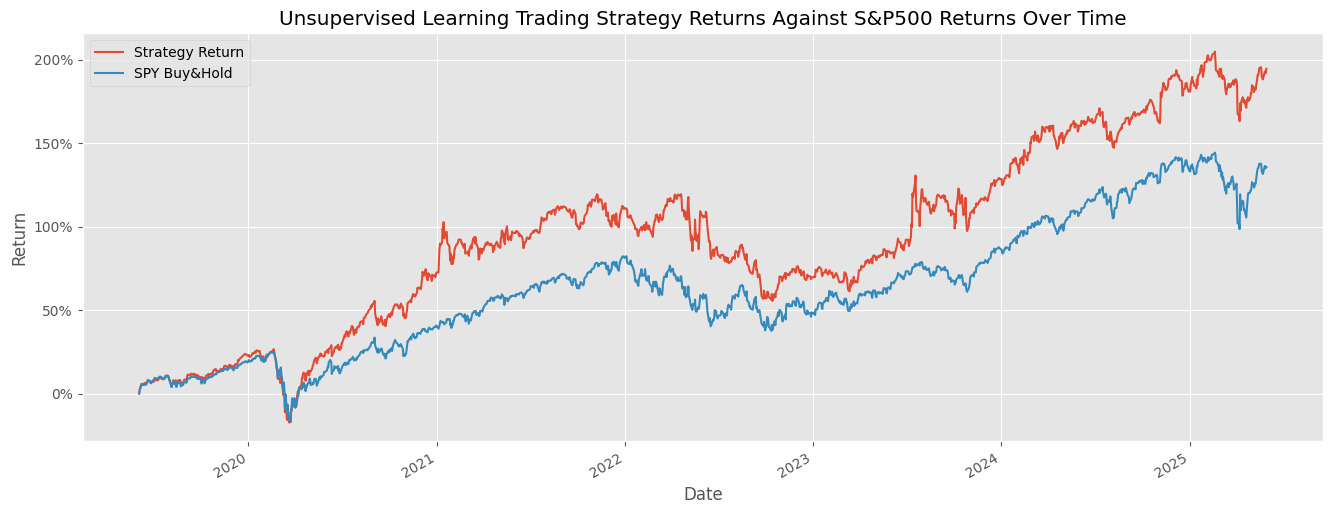

In [21]:
# Plot both returns
(cumulative_returns - 1).plot(figsize=(16,6))
plt.title('Unsupervised Learning Trading Strategy Returns Against S&P500 Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()

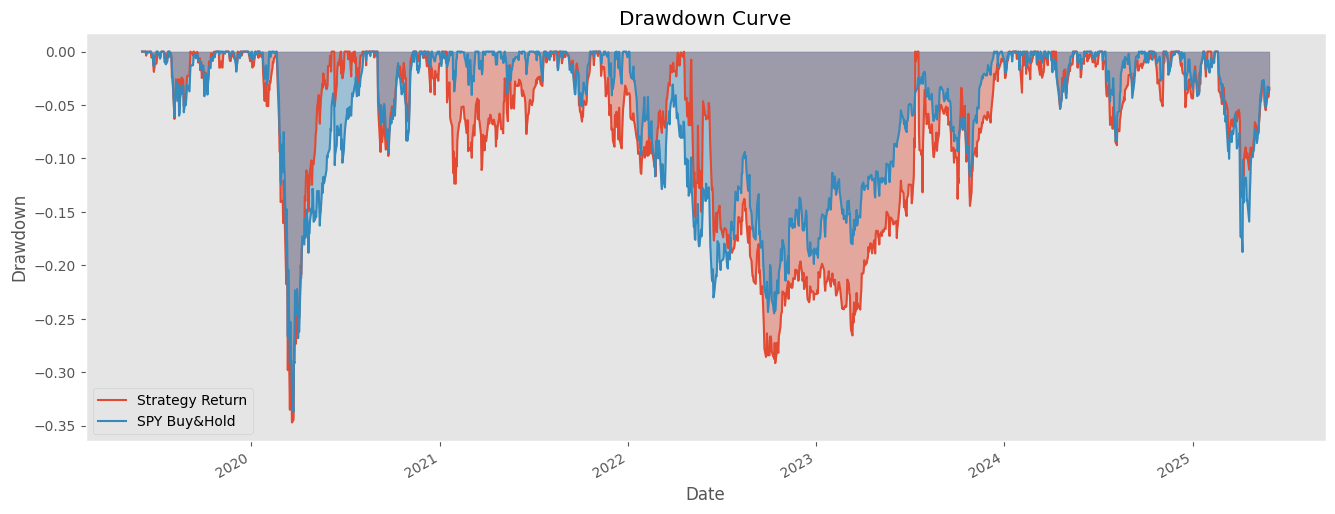

In [22]:
cummax = cumulative_returns.cummax()
drawdown = (cumulative_returns) / cummax - 1
ax = drawdown.plot(figsize=(16,6))

# Get the colors of the plotted lines from the axes
colors = [line.get_color() for line in ax.get_lines()]

# Fill between each drawdown line and y=0 with the same color
for i, column in enumerate(drawdown.columns):
    ax.fill_between(drawdown.index, drawdown[column], 0, color=colors[i], alpha=0.4)
    
plt.title('Drawdown Curve')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid()
plt.show()

In [23]:
# Calculate daily returns
risk_free_rate = 0.041
daily_rfr = (1 + risk_free_rate) ** (1/252) - 1

daily_returns = cumulative_returns.pct_change().dropna()

# Annualized return
annualised_returns = (1 + daily_returns.mean()) ** 252 - 1

# Annualized volatility
annualised_volatility = daily_returns.std() * np.sqrt(252)

# Sharpe ratio (assuming 0 risk-free rate)
sharpe_ratio = ((daily_returns.mean() - daily_rfr) / daily_returns.std()) * np.sqrt(252)

print('Annualized Returns:', annualised_returns.to_string(), sep='\n')
print('\nAnnualized Volatility:', annualised_volatility.to_string(), sep='\n')
print('\nSharpe Ratios:', sharpe_ratio.to_string(), sep='\n')

Annualized Returns:
Strategy Return    0.231651
SPY Buy&Hold       0.179437

Annualized Volatility:
Strategy Return    0.235252
SPY Buy&Hold       0.208351

Sharpe Ratios:
Strategy Return    0.715219
SPY Buy&Hold       0.599499


In [24]:
# Calculate excess returns
excess_strategy = combined_df.iloc[:,0] - daily_rfr
excess_spy = combined_df.iloc[:,1] - daily_rfr

# Regression: excess strategy returns on excess benchmark returns
X = sm.add_constant(excess_spy)
model = sm.OLS(excess_strategy, X).fit()

alpha_daily = model.params.iloc[0]
beta = model.params.iloc[1]

print(f"Beta: {beta:.4f}")

# Annualize alpha: multiply daily alpha by trading days per year (252)
alpha_annualized = alpha_daily * 252
print(f"Alpha (annualised): {alpha_annualized:.4f}")

# Optional: print full regression summary
print(model.summary())

Beta: 0.8706
Alpha (annualised): 0.0595
                            OLS Regression Results                            
Dep. Variable:        Strategy Return   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2208.
Date:                Mon, 09 Jun 2025   Prob (F-statistic):          1.58e-297
Time:                        16:50:29   Log-Likelihood:                 4893.3
No. Observations:                1508   AIC:                            -9783.
Df Residuals:                    1506   BIC:                            -9772.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const   